# 06 - EfficientNetB3 Transfer Learning: Amélioration du Modèle

**Objectif:** Dépasser F1 = 0.60 (meilleur résultat VGG16)

**Architecture:** EfficientNetB3 (ImageNet) + Classifier Head | **Images:** 300×300 | **Batch:** 32

**Stratégie 2-Phase:**
- Phase 1: EfficientNet gelé, entraînement classifier (~12-15 époques)
- Phase 2: Dégeler top 20 couches, fine-tuning (~6-8 époques)

**Cible:** F1 = 0.64-0.68 (+7-13% vs VGG16)

**🔵 Optimisé pour Google Colab + Keras 3**

---

## 🔧 Environnement

In [1]:
import sys, os
from pathlib import Path

IS_COLAB = 'google.colab' in sys.modules
if IS_COLAB:
    print("🔵 Google Colab")
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    PROJECT_ROOT = Path('/content/drive/MyDrive/sep25_alt1_mle_ds_rakuten')
    os.chdir(PROJECT_ROOT)
else:
    print("🟢 Local")
    PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
    os.chdir(PROJECT_ROOT)

print(f"📁 {PROJECT_ROOT}")

🔵 Google Colab
Mounted at /content/drive
📁 /content/drive/MyDrive/sep25_alt1_mle_ds_rakuten


## 📦 Imports

In [2]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt, seaborn as sns
import pickle, json, shutil
from datetime import datetime
import warnings; warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, EarlyStopping
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.applications.efficientnet import preprocess_input
from sklearn.metrics import f1_score, accuracy_score, classification_report, confusion_matrix

np.random.seed(42)
tf.random.set_seed(42)

# GPU check
gpus = tf.config.list_physical_devices('GPU')
print(f"TensorFlow: {tf.__version__}")
if gpus:
    print(f"✅ GPU: {gpus}")
else:
    print("❌ Pas de GPU! → Runtime > Change runtime type > T4 GPU")

INPUT_DIR  = Path('output/03_preprocessing_resampling')
OUTPUT_DIR = Path('output/06_efficientnet_b3')
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

print("\n✅ Imports OK")

TensorFlow: 2.19.0
✅ GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

✅ Imports OK


## 🏷️ Labels Catégories

In [3]:
# Labels des catégories
prdtypecode_labels = {
    10: "Livre usagé",
    40: "Jeux vidéo et accessoires tech",
    50: "Accessoires de console",
    60: "Console de jeux vidéo",
    1140: "Statuette / Figurine",
    1160: "Cartes collectionnables",
    1180: "Jeux de table",
    1280: "Jouets enfants et costumes",
    1281: "Jeux de société",
    1300: "Jouets électroniques",
    1301: "Bas et chaussettes",
    1302: "Jeux extérieurs et vêtements",
    1320: "Articles pour bébé",
    1560: "Meubles intérieurs",
    1920: "Mobilier de chambre",
    1940: "Ustensiles de cuisine",
    2060: "Décoration intérieure",
    2220: "Produits pour animaux",
    2280: "Magazines et journaux",
    2403: "Livres, magazines et BD",
    2462: "Jeux d'occasion",
    2522: "Matériel de bureau",
    2582: "Mobilier de jardin",
    2583: "Équipement de piscine",
    2585: "Outillage et bricolage",
    2705: "Livre nouveau",
    2905: "Jeux pour PC"
}

print("✅ Labels définis")

✅ Labels définis


## 🚀 Copie Images → SSD Colab

**CRITIQUE:** Les images sont sur Drive (lent). On les copie sur le SSD local de Colab (rapide).

⏱️ La copie prend 10-20 min **une seule fois par session**.

In [4]:
DRIVE_IMAGE_DIR = Path('output/02_preprocessing_images/images_zoomed')
SSD_IMAGE_DIR   = Path('/content/images_zoomed')

if IS_COLAB:
    if not SSD_IMAGE_DIR.exists():
        print(f"📦 Copie Drive → SSD Colab...")
        print(f"   Source: {DRIVE_IMAGE_DIR}")
        print(f"   Dest:   {SSD_IMAGE_DIR}")
        print(f"   ⏱️  ~10-20 minutes, une seule fois par session\n")
        shutil.copytree(src=DRIVE_IMAGE_DIR, dst=SSD_IMAGE_DIR)
        print(f"\n✅ Copie terminée!")
    else:
        print(f"✅ Images déjà sur SSD: {SSD_IMAGE_DIR}")
    IMAGE_DIR = SSD_IMAGE_DIR
else:
    # Local: use Drive images directly (fast local disk)
    IMAGE_DIR = DRIVE_IMAGE_DIR

# Verify
n_classes_found = len(list(IMAGE_DIR.iterdir())) if IMAGE_DIR.exists() else 0
print(f"🚀 IMAGE_DIR = {IMAGE_DIR}")
print(f"   Dossiers classes trouvés: {n_classes_found}")

📦 Copie Drive → SSD Colab...
   Source: output/02_preprocessing_images/images_zoomed
   Dest:   /content/images_zoomed
   ⏱️  ~10-20 minutes, une seule fois par session


✅ Copie terminée!
🚀 IMAGE_DIR = /content/images_zoomed
   Dossiers classes trouvés: 27


## ⚙️ Configuration

In [5]:
MODEL_ID = "efficientnet_b3_001"

CONFIG = {
    'model_id': MODEL_ID,
    'image_size': (300, 300, 3),  # EfficientNetB3 native size
    'batch_size': 32,             # Smaller batch for larger images
    'phase1_epochs': 20,           # Frozen EfficientNet
    'phase2_epochs': 10,           # Fine-tuning
    'phase1_lr': 0.001,
    'phase2_lr': 0.0001,
    'dropout_rate': 0.3,           # Higher than VGG16 (0.2)
}

AUGMENTATION = {
    'preprocessing_function': preprocess_input,
    'rotation_range': 20,
    'width_shift_range': 0.2,
    'height_shift_range': 0.2,
    'shear_range': 5,
    'zoom_range': 0.15,            # Slightly more than VGG16 (0.1)
    'brightness_range': [0.8, 1.2], # NEW: lighting variation
    'horizontal_flip': True,
    'vertical_flip': True,
    'fill_mode': 'nearest'
}

print(f"📋 EfficientNetB3 Transfer Learning")
print(f"   Images: {CONFIG['image_size'][:2]} | Batch: {CONFIG['batch_size']}")
print(f"   Phase 1: {CONFIG['phase1_epochs']} époques (frozen, LR={CONFIG['phase1_lr']})")
print(f"   Phase 2: {CONFIG['phase2_epochs']} époques (top 20 layers unfrozen, LR={CONFIG['phase2_lr']})")
print(f"   Dropout: {CONFIG['dropout_rate']} | Brightness augmentation: ✅")

📋 EfficientNetB3 Transfer Learning
   Images: (300, 300) | Batch: 32
   Phase 1: 20 époques (frozen, LR=0.001)
   Phase 2: 10 époques (top 20 layers unfrozen, LR=0.0001)
   Dropout: 0.3 | Brightness augmentation: ✅


## 📊 Chargement Données

In [6]:
df_train = pd.read_csv(INPUT_DIR / 'df_train.csv', index_col=0)
df_val   = pd.read_csv(INPUT_DIR / 'df_val.csv',   index_col=0)
df_test  = pd.read_csv(INPUT_DIR / 'df_test.csv',  index_col=0)

# prdtypecode doit être string pour flow_from_dataframe
for df in [df_train, df_val, df_test]:
    df['prdtypecode'] = df['prdtypecode'].astype(str)

classes     = sorted(df_train['prdtypecode'].unique(), key=lambda x: int(x))
num_classes = len(classes)

print(f"Train: {len(df_train):,} | Val: {len(df_val):,} | Test: {len(df_test):,}")
print(f"Classes: {num_classes}")

Train: 109,566 | Val: 8,492 | Test: 8,492
Classes: 27


## 🖼️ Générateurs

In [7]:
train_datagen = ImageDataGenerator(**AUGMENTATION)
train_gen = train_datagen.flow_from_dataframe(
    dataframe=df_train, directory=IMAGE_DIR,
    x_col='imagefile_relative', y_col='prdtypecode',
    target_size=CONFIG['image_size'][:2], batch_size=CONFIG['batch_size'],
    class_mode='categorical', classes=classes, shuffle=True, seed=42
)

val_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)
val_gen = val_datagen.flow_from_dataframe(
    dataframe=df_val, directory=IMAGE_DIR,
    x_col='imagefile_relative', y_col='prdtypecode',
    target_size=CONFIG['image_size'][:2], batch_size=CONFIG['batch_size'],
    class_mode='categorical', classes=classes, shuffle=False
)

test_gen = val_datagen.flow_from_dataframe(
    dataframe=df_test, directory=IMAGE_DIR,
    x_col='imagefile_relative', y_col='prdtypecode',
    target_size=CONFIG['image_size'][:2], batch_size=CONFIG['batch_size'],
    class_mode='categorical', classes=classes, shuffle=False
)

print(f"\n✅ Train: {train_gen.samples:,} | Val: {val_gen.samples:,} | Test: {test_gen.samples:,}")

Found 109566 validated image filenames belonging to 27 classes.
Found 8492 validated image filenames belonging to 27 classes.
Found 8492 validated image filenames belonging to 27 classes.

✅ Train: 109,566 | Val: 8,492 | Test: 8,492


## 🏗️ Architecture EfficientNetB3 + Classifier

In [8]:
def build_efficientnet_model(input_shape, num_classes, dropout_rate=0.3):
    """
    EfficientNetB3 (ImageNet) + Custom Classifier Head
    Tous les layers EfficientNet sont gelés initialement
    """
    base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=input_shape)

    # Geler tous les layers EfficientNet
    for layer in base_model.layers:
        layer.trainable = False

    print(f"📊 EfficientNetB3 layers: {len(base_model.layers)}")

    # Classifier head
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(1024, activation='relu'),
        Dropout(dropout_rate),
        Dense(512, activation='relu'),
        Dropout(dropout_rate),
        Dense(num_classes, activation='softmax')
    ], name='EfficientNetB3_Transfer')

    return model

print("✅ Architecture EfficientNetB3 définie")

✅ Architecture EfficientNetB3 définie


## 🔄 Checkpoints

In [9]:
class CheckpointManager:
    def __init__(self, model_id, output_dir):
        self.model_id     = model_id
        self.output_dir   = Path(output_dir)
        self.phase1_path  = self.output_dir / f"{model_id}_phase1.keras"
        self.phase2_path  = self.output_dir / f"{model_id}_phase2.keras"
        self.history_path = self.output_dir / f"{model_id}_history.pkl"
        self.log_path     = self.output_dir / f"{model_id}_log.json"
        self.log          = self._load_log()

    def _load_log(self):
        if self.log_path.exists():
            with open(self.log_path) as f: return json.load(f)
        return {'model_id': self.model_id, 'created_at': datetime.now().isoformat(),
                'phase1_done': False, 'phase2_done': False,
                'phase1_best_f1': 0.0, 'phase2_best_f1': 0.0}

    def save_log(self):
        with open(self.log_path, 'w') as f: json.dump(self.log, f, indent=2)

    def save_phase1(self, model):
        model.save(self.phase1_path)
        print(f"💾 Phase 1 sauvegardée: {self.phase1_path.name}")

    def save_phase2(self, model):
        model.save(self.phase2_path)
        print(f"💾 Phase 2 sauvegardée: {self.phase2_path.name}")

    def load_phase1(self):
        if self.phase1_path.exists():
            print(f"📂 Chargement Phase 1: {self.phase1_path.name}")
            return load_model(self.phase1_path)
        return None

    def load_phase2(self):
        if self.phase2_path.exists():
            print(f"📂 Chargement Phase 2: {self.phase2_path.name}")
            return load_model(self.phase2_path)
        return None

    def save_history(self, history_dict):
        existing = self.load_history() or {}
        for k, v in history_dict.items():
            existing[k] = existing.get(k, []) + (v if isinstance(v, list) else list(v))
        with open(self.history_path, 'wb') as f: pickle.dump(existing, f)

    def load_history(self):
        if self.history_path.exists():
            with open(self.history_path, 'rb') as f: return pickle.load(f)
        return None

checkpoint = CheckpointManager(MODEL_ID, OUTPUT_DIR)
print(f"✅ Checkpoint | Phase 1: {checkpoint.log['phase1_done']} | Phase 2: {checkpoint.log['phase2_done']}")

✅ Checkpoint | Phase 1: False | Phase 2: False


## 📝 Callbacks

In [10]:
class F1Callback(Callback):
    def __init__(self, val_gen, checkpoint, phase):
        super().__init__()
        self.val_gen    = val_gen
        self.checkpoint = checkpoint
        self.phase      = phase
        self.best_f1    = 0.0
        self.history    = {'train_loss': [], 'train_acc': [],
                           'val_loss': [], 'val_acc': [], 'val_f1': []}

    def on_epoch_end(self, epoch, logs=None):
        self.val_gen.reset()
        y_pred_proba = self.model.predict(self.val_gen, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)
        y_true = self.val_gen.classes
        val_f1 = f1_score(y_true, y_pred, average='weighted', zero_division=0)

        self.history['train_loss'].append(float(logs.get('loss', 0)))
        self.history['train_acc'].append(float(logs.get('accuracy', 0)))
        self.history['val_loss'].append(float(logs.get('val_loss', 0)))
        self.history['val_acc'].append(float(logs.get('val_accuracy', 0)))
        self.history['val_f1'].append(float(val_f1))

        print(f"  → val_f1: {val_f1:.4f}", end='')

        if val_f1 > self.best_f1:
            self.best_f1 = val_f1
            self.checkpoint.log[f'{self.phase}_best_f1'] = float(val_f1)
            self.checkpoint.log[f'{self.phase}_best_epoch'] = epoch + 1
            if self.phase == 'phase1':
                self.checkpoint.save_phase1(self.model)
            else:
                self.checkpoint.save_phase2(self.model)
            print(f" 🎯 Nouveau meilleur!", end='')

        print()
        self.checkpoint.save_log()


# Early Stopping - monitor val_loss (most stable metric)
early_stopping = EarlyStopping(
    monitor='val_loss',
    mode='min',
    patience=5,
    min_delta=0.01,
    verbose=1
)

print("✅ Callbacks définis (Early stopping: val_loss, patience=5)")

✅ Callbacks définis (Early stopping: val_loss, patience=5)


## 🏃 PHASE 1: Entraînement Classifier (EfficientNet Gelé)

**⏱️ Durée: ~3 heures sur T4**

In [11]:
model = checkpoint.load_phase1()

if model is None and not checkpoint.log['phase1_done']:
    print("\n🏗️ Construction EfficientNetB3 (Phase 1)...")
    model = build_efficientnet_model(CONFIG['image_size'], num_classes, CONFIG['dropout_rate'])
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['phase1_lr']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    print("✅ Compilé")

if model is not None:
    model.summary()


🏗️ Construction EfficientNetB3 (Phase 1)...
43941136/43941136 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
📊 EfficientNetB3 layers: 385
✅ Compilé


Model: "EfficientNetB3_Transfer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb3 (Functional)     │ (None, 10, 10, 1536)   │    10,783,535 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1536)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,573,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 27)             │        13,851 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,896,074 (49.19 MB)

 Trainable params: 2,112,539 (8.06 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [12]:
if not checkpoint.log['phase1_done']:
    print(f"\n🎯 PHASE 1: Entraînement avec EfficientNetB3 gelé...\n")

    f1_cb = F1Callback(val_gen, checkpoint, 'phase1')

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['phase1_epochs'],
        steps_per_epoch=train_gen.samples // CONFIG['batch_size'],
        validation_steps=val_gen.samples // CONFIG['batch_size'],
        callbacks=[f1_cb, early_stopping],
        verbose=1
    )

    checkpoint.log['phase1_done'] = True
    checkpoint.save_log()
    checkpoint.save_history(f1_cb.history)

    print("\n✅ Phase 1 terminée!")
    print(f"   Meilleur val F1: {checkpoint.log['phase1_best_f1']:.4f}")
else:
    print("\n⏭️ Phase 1 déjà terminée")
    print(f"   Meilleur val F1: {checkpoint.log['phase1_best_f1']:.4f}")


🎯 PHASE 1: Entraînement avec EfficientNetB3 gelé...

Epoch 1/20
3423/3423 ━━━━━━━━━━━━━━━━━━━━ 0s 401ms/step - accuracy: 0.4422 - loss: 1.8842  → val_f1: 0.5613💾 Phase 1 sauvegardée: efficientnet_b3_001_phase1.keras
 🎯 Nouveau meilleur!
3423/3423 ━━━━━━━━━━━━━━━━━━━━ 1497s 425ms/step - accuracy: 0.4422 - loss: 1.8842 - val_accuracy: 0.5573 - val_loss: 1.4509
Epoch 2/20
   1/3423 ━━━━━━━━━━━━━━━━━━━━ 1:02 18ms/step - accuracy: 0.5000 - loss: 1.7501  → val_f1: 0.5633💾 Phase 1 sauvegardée: efficientnet_b3_001_phase1.keras
 🎯 Nouveau meilleur!
3423/3423 ━━━━━━━━━━━━━━━━━━━━ 35s 10ms/step - accuracy: 0.5000 - loss: 1.7501 - val_accuracy: 0.5606 - val_loss: 1.4466
Epoch 3/20
3423/3423 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - accuracy: 0.5656 - loss: 1.4305  → val_f1: 0.5750💾 Phase 1 sauvegardée: efficientnet_b3_001_phase1.keras
 🎯 Nouveau meilleur!
3423/3423 ━━━━━━━━━━━━━━━━━━━━ 1358s 397ms/step - accuracy: 0.5656 - loss: 1.4305 - val_accuracy: 0.5696 - val_loss: 1.3883
Epoch 4/20
   1/3423 ━━━

## 🔓 PHASE 2: Fine-Tuning (Dégeler Top 20 Couches EfficientNet)

**⏱️ Durée: ~1.5-2 heures sur T4**

In [13]:
if checkpoint.log['phase1_done'] and not checkpoint.log['phase2_done']:
    print("\n🔓 PHASE 2: Préparation fine-tuning...")

    # Charger meilleur modèle Phase 1
    model = checkpoint.load_phase1()

    # Dégeler top 20 couches EfficientNet
    efficientnet_base = model.layers[0]
    total_layers = len(efficientnet_base.layers)

    print(f"   Total EfficientNet layers: {total_layers}")
    print(f"   Dégelant les 20 dernières couches...")

    for layer in efficientnet_base.layers[-20:]:
        layer.trainable = True

    trainable_count = sum([1 for l in efficientnet_base.layers if l.trainable])
    print(f"   Couches entraînables: {trainable_count}/{total_layers}")

    # Recompiler avec LR plus bas
    model.compile(
        optimizer=Adam(learning_rate=CONFIG['phase2_lr']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )

    print(f"✅ Recompilé avec LR={CONFIG['phase2_lr']}")
    print(f"\n📊 Paramètres entraînables: {model.count_params():,}")


🔓 PHASE 2: Préparation fine-tuning...
📂 Chargement Phase 1: efficientnet_b3_001_phase1.keras
   Total EfficientNet layers: 385
   Dégelant les 20 dernières couches...
   Couches entraînables: 21/385
✅ Recompilé avec LR=0.0001

📊 Paramètres entraînables: 12,896,074


In [14]:
if checkpoint.log['phase1_done'] and not checkpoint.log['phase2_done']:
    print(f"\n🎯 PHASE 2: Fine-tuning EfficientNetB3...\n")

    f1_cb = F1Callback(val_gen, checkpoint, 'phase2')

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=CONFIG['phase2_epochs'],
        steps_per_epoch=train_gen.samples // CONFIG['batch_size'],
        validation_steps=val_gen.samples // CONFIG['batch_size'],
        callbacks=[f1_cb, early_stopping],
        verbose=1
    )

    checkpoint.log['phase2_done'] = True
    checkpoint.save_log()
    checkpoint.save_history(f1_cb.history)

    print("\n✅ Phase 2 terminée!")
    print(f"   Meilleur val F1: {checkpoint.log['phase2_best_f1']:.4f}")
else:
    print("\n⏭️ Phase 2 déjà terminée ou Phase 1 non terminée")
    if checkpoint.log['phase2_done']:
        print(f"   Meilleur val F1: {checkpoint.log['phase2_best_f1']:.4f}")


🎯 PHASE 2: Fine-tuning EfficientNetB3...

Epoch 1/10
3423/3423 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step - accuracy: 0.6411 - loss: 1.1805  → val_f1: 0.6166💾 Phase 2 sauvegardée: efficientnet_b3_001_phase2.keras
 🎯 Nouveau meilleur!
3423/3423 ━━━━━━━━━━━━━━━━━━━━ 1537s 440ms/step - accuracy: 0.6411 - loss: 1.1805 - val_accuracy: 0.6160 - val_loss: 1.2534
Epoch 2/10
   1/3423 ━━━━━━━━━━━━━━━━━━━━ 1:17 23ms/step - accuracy: 0.6562 - loss: 1.0433  → val_f1: 0.6165
3423/3423 ━━━━━━━━━━━━━━━━━━━━ 39s 11ms/step - accuracy: 0.6562 - loss: 1.0433 - val_accuracy: 0.6159 - val_loss: 1.2534
Epoch 3/10
3423/3423 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - accuracy: 0.6950 - loss: 0.9800  → val_f1: 0.6287💾 Phase 2 sauvegardée: efficientnet_b3_001_phase2.keras
 🎯 Nouveau meilleur!
3423/3423 ━━━━━━━━━━━━━━━━━━━━ 1387s 405ms/step - accuracy: 0.6950 - loss: 0.9800 - val_accuracy: 0.6288 - val_loss: 1.2201
Epoch 4/10
   1/3423 ━━━━━━━━━━━━━━━━━━━━ 1:02 18ms/step - accuracy: 0.6875 - loss: 0.9225  → val_f1: 0.6289💾 P

## 📊 Courbes d'Entraînement

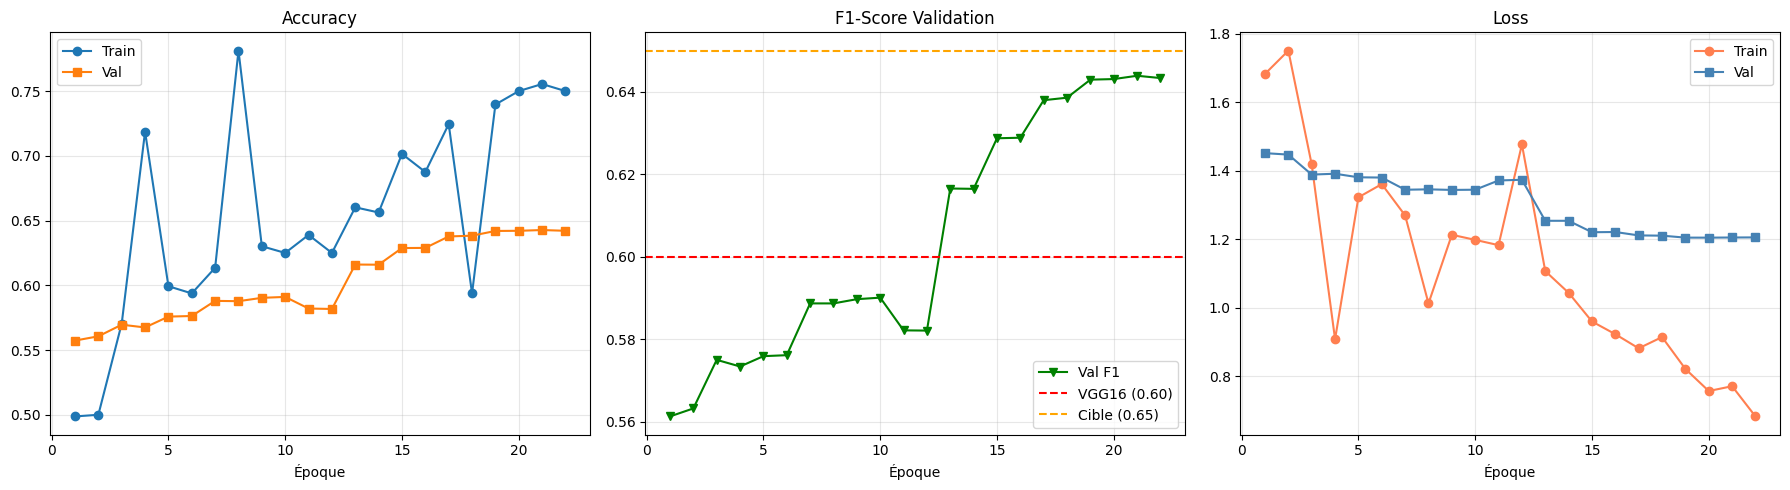

Meilleur val F1: 0.6439 (époque 21)


In [15]:
history = checkpoint.load_history()

if history:
    epochs_range = range(1, len(history['train_loss']) + 1)
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))

    axes[0].plot(epochs_range, history['train_acc'], label='Train', marker='o')
    axes[0].plot(epochs_range, history['val_acc'],   label='Val',   marker='s')
    axes[0].set_title('Accuracy'); axes[0].set_xlabel('Époque')
    axes[0].legend(); axes[0].grid(alpha=0.3)

    axes[1].plot(epochs_range, history['val_f1'], label='Val F1', marker='v', color='green')
    axes[1].axhline(y=0.60, color='red', linestyle='--', label='VGG16 (0.60)')
    axes[1].axhline(y=0.65, color='orange', linestyle='--', label='Cible (0.65)')
    axes[1].set_title('F1-Score Validation'); axes[1].set_xlabel('Époque')
    axes[1].legend(); axes[1].grid(alpha=0.3)

    axes[2].plot(epochs_range, history['train_loss'], label='Train', marker='o', color='coral')
    axes[2].plot(epochs_range, history['val_loss'],   label='Val',   marker='s', color='steelblue')
    axes[2].set_title('Loss'); axes[2].set_xlabel('Époque')
    axes[2].legend(); axes[2].grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'training_history.png', dpi=150, bbox_inches='tight')
    plt.show()

    best_epoch = int(np.argmax(history['val_f1'])) + 1
    print(f"Meilleur val F1: {max(history['val_f1']):.4f} (époque {best_epoch})")
else:
    print("Pas d'historique trouvé")

## 🎯 Évaluation Test

In [16]:
# Charger le meilleur modèle (Phase 2 si terminée, sinon Phase 1)
if checkpoint.log['phase2_done']:
    model = checkpoint.load_phase2()
    print("📂 Évaluation avec modèle Phase 2 (fine-tuned)")
elif checkpoint.log['phase1_done']:
    model = checkpoint.load_phase1()
    print("📂 Évaluation avec modèle Phase 1 (EfficientNet gelé)")
else:
    print("❌ Aucun modèle entraîné à évaluer")
    model = None

if model is not None:
    test_gen.reset()
    y_pred_proba = model.predict(test_gen, verbose=1)
    y_pred = np.argmax(y_pred_proba, axis=1)
    y_true = test_gen.classes

    test_f1  = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    test_acc = accuracy_score(y_true, y_pred)

    print(f"\n📊 Test - F1: {test_f1:.4f} | Accuracy: {test_acc:.4f}")

    checkpoint.log['test_f1']  = float(test_f1)
    checkpoint.log['test_acc'] = float(test_acc)
    checkpoint.save_log()

📂 Chargement Phase 2: efficientnet_b3_001_phase2.keras
📂 Évaluation avec modèle Phase 2 (fine-tuned)
266/266 ━━━━━━━━━━━━━━━━━━━━ 40s 107ms/step

📊 Test - F1: 0.6552 | Accuracy: 0.6537


## 📋 Rapport & Matrice Confusion

In [17]:
if model is not None:
    class_labels = [prdtypecode_labels[int(c)] for c in classes]

    report = classification_report(y_true, y_pred, target_names=class_labels, digits=4)
    print(report)
    with open(OUTPUT_DIR / 'classification_report.txt', 'w') as f:
        f.write(report)
    print("✅ Sauvegardé: classification_report.txt")

                                precision    recall  f1-score   support

                   Livre usagé     0.4738    0.4952    0.4843       311
Jeux vidéo et accessoires tech     0.6107    0.6375    0.6238       251
        Accessoires de console     0.4836    0.6131    0.5407       168
         Console de jeux vidéo     0.6882    0.7711    0.7273        83
          Statuette / Figurine     0.6680    0.6479    0.6578       267
       Cartes collectionnables     0.9313    0.9242    0.9278       396
                 Jeux de table     0.4769    0.4079    0.4397        76
    Jouets enfants et costumes     0.5514    0.3634    0.4381       487
               Jeux de société     0.3256    0.4058    0.3613       207
          Jouets électroniques     0.7107    0.7881    0.7474       505
            Bas et chaussettes     0.7317    0.7407    0.7362        81
  Jeux extérieurs et vêtements     0.4966    0.5904    0.5394       249
            Articles pour bébé     0.5049    0.6358    0.5628  

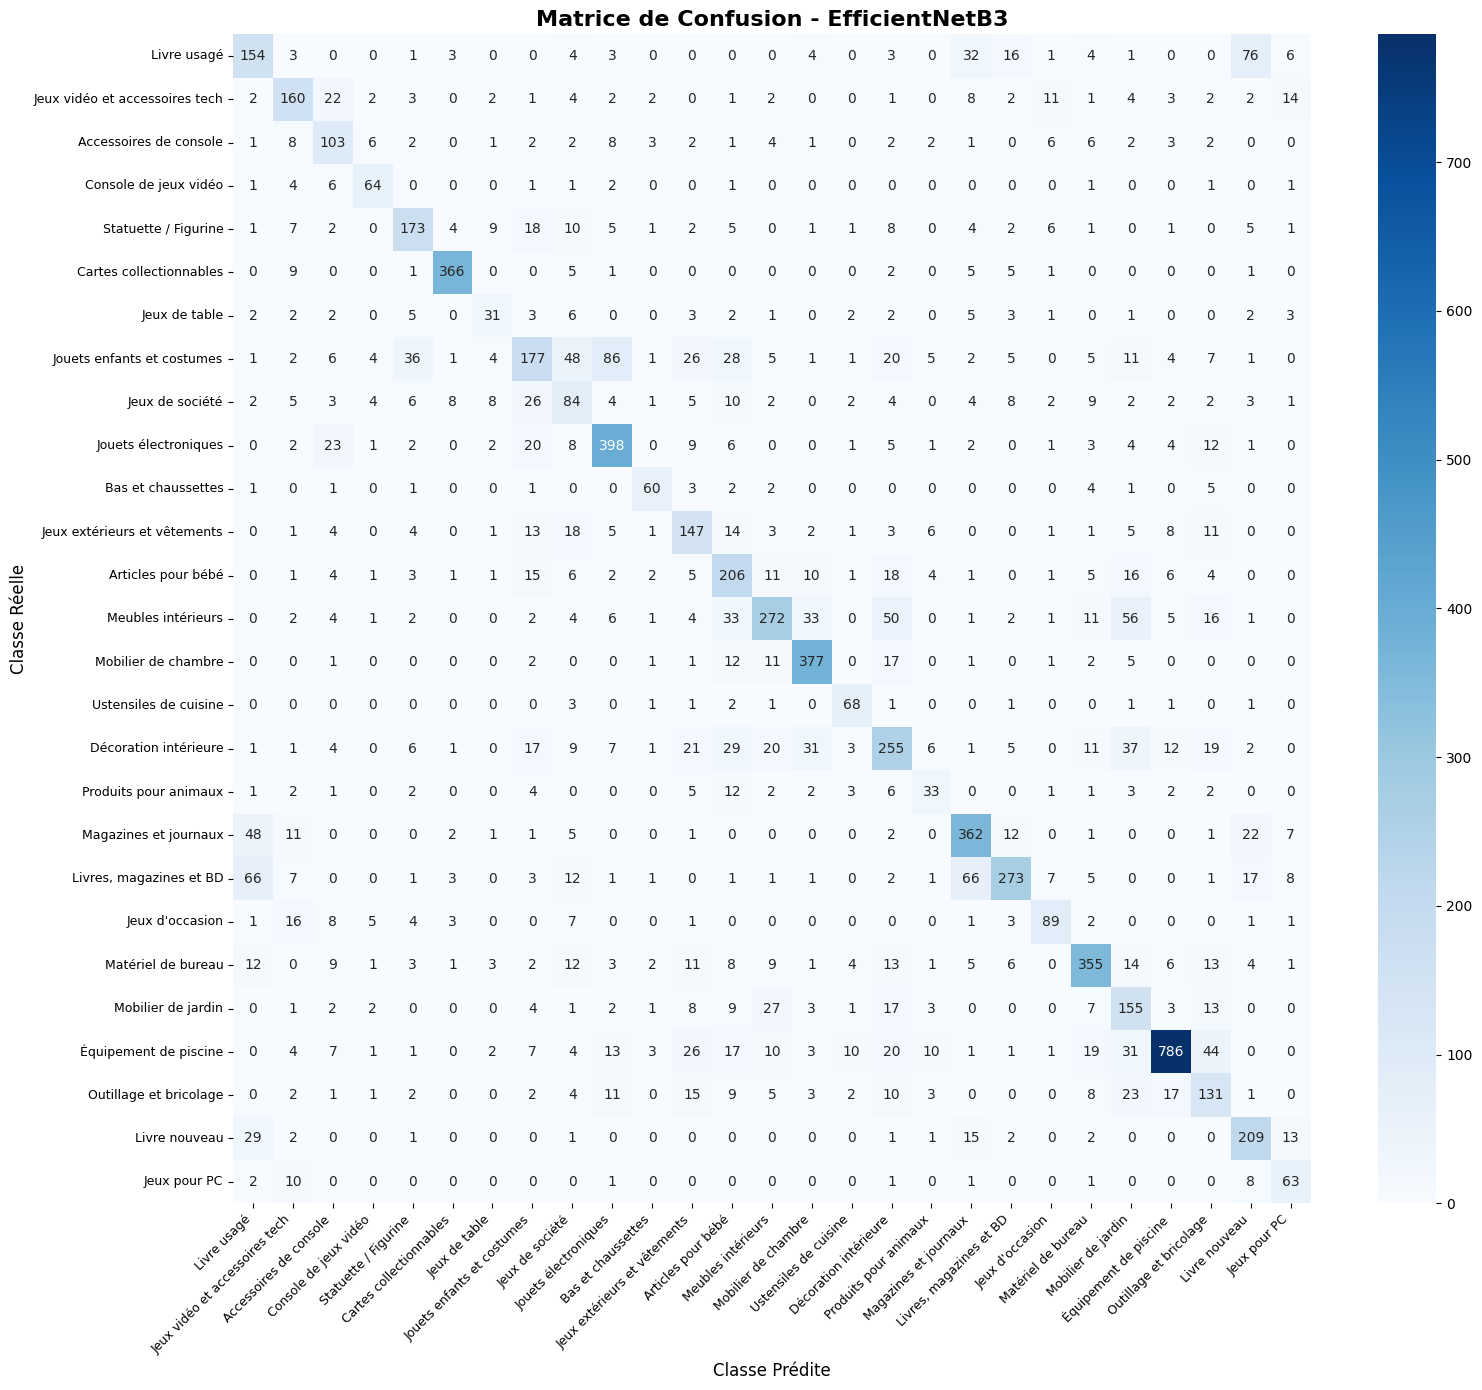

In [18]:
if model is not None:
    cm = confusion_matrix(y_true, y_pred)

    plt.figure(figsize=(16, 14))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_labels, yticklabels=class_labels)
    plt.title('Matrice de Confusion - EfficientNetB3', fontsize=16, fontweight='bold')
    plt.xlabel('Classe Prédite', fontsize=12)
    plt.ylabel('Classe Réelle', fontsize=12)
    plt.xticks(rotation=45, ha='right', fontsize=9)
    plt.yticks(rotation=0, fontsize=9)
    plt.tight_layout()
    plt.savefig(OUTPUT_DIR / 'confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

## 📋 Résumé Final & Comparaison

In [19]:
if model is not None:
    print("=" * 70)
    print("🏆 RÉSULTATS FINAUX - EFFICIENTNETB3 TRANSFER LEARNING")
    print("=" * 70)
    print(f"Train: {len(df_train):,} | Val: {len(df_val):,} | Test: {len(df_test):,}")
    print(f"\n📊 Phase 1 (EfficientNet gelé):")
    print(f"   Meilleur val F1: {checkpoint.log['phase1_best_f1']:.4f}")
    if checkpoint.log['phase2_done']:
        print(f"\n📊 Phase 2 (Fine-tuning top 20 layers):")
        print(f"   Meilleur val F1: {checkpoint.log['phase2_best_f1']:.4f}")
    print(f"\n🎯 Test:")
    print(f"   F1-Score: {test_f1:.4f}")
    print(f"   Accuracy: {test_acc:.4f}")

    print(f"\n📈 Comparaison avec Modèles Précédents:")
    print(f"   LeNet (baseline):      0.3100")
    print(f"   VGG16 (Model 331):     0.6000")
    print(f"   EfficientNetB3 (now):  {test_f1:.4f}")

    diff_lenet = test_f1 - 0.31
    diff_vgg = test_f1 - 0.60

    print(f"\n🎯 Amélioration:")
    print(f"   vs LeNet:  {diff_lenet:+.4f} ({diff_lenet/0.31*100:+.1f}%)")
    print(f"   vs VGG16:  {diff_vgg:+.4f} ({diff_vgg/0.60*100:+.1f}%)")

    if test_f1 > 0.64:
        print("   ✅ Objectif atteint! (>0.64)")
    elif test_f1 > 0.60:
        print(f"   ✅ Amélioration vs VGG16! (+{diff_vgg*100:.1f}%)")
    else:
        print(f"   ⚠️ En dessous de VGG16 - envisager ensemble")

    print(f"\n📁 Sorties: {OUTPUT_DIR}")
    print("=" * 70)

🏆 RÉSULTATS FINAUX - EFFICIENTNETB3 TRANSFER LEARNING
Train: 109,566 | Val: 8,492 | Test: 8,492

📊 Phase 1 (EfficientNet gelé):
   Meilleur val F1: 0.5901

📊 Phase 2 (Fine-tuning top 20 layers):
   Meilleur val F1: 0.6439

🎯 Test:
   F1-Score: 0.6552
   Accuracy: 0.6537

📈 Comparaison avec Modèles Précédents:
   LeNet (baseline):      0.3100
   VGG16 (Model 331):     0.6000
   EfficientNetB3 (now):  0.6552

🎯 Amélioration:
   vs LeNet:  +0.3452 (+111.4%)
   vs VGG16:  +0.0552 (+9.2%)
   ✅ Objectif atteint! (>0.64)

📁 Sorties: output/06_efficientnet_b3
